# Example: Graph generation from a gene

This notebook will show you how to use the tool to generate a KG on the underlying data.

In [1]:
import os

os.chdir("../")

# Set the current working directory
current_dir = os.getcwd()
print("Current directory:", current_dir)

Current directory: /home/javi/code/pyBiodatafuse-2


In [2]:
# Import modules
import pickle

import pandas as pd
from dotenv import load_dotenv
from pyBiodatafuse import id_mapper
from pyBiodatafuse.annotators import (
    bgee,
    disgenet,
    minerva,
    molmedb,
    opentargets,
    pubchem,
    stringdb,
    wikipathways,
)
from pyBiodatafuse.constants import (
    BGEE_GENE_EXPRESSION_LEVELS_COL,
    DISGENET_DISEASE_COL,
    MINERVA,
    MOLMEDB_PROTEIN_COMPOUND_COL,
    OPENTARGETS_DISEASE_COMPOUND_COL,
    OPENTARGETS_GENE_COMPOUND_COL,
    OPENTARGETS_GO_COL,
    OPENTARGETS_REACTOME_COL,
    PUBCHEM_COMPOUND_ASSAYS_COL,
    STRING_PPI_COL,
    WIKIPATHWAYS,
)
from pyBiodatafuse.graph import generator, rdf
from pyBiodatafuse.utils import combine_sources, create_harmonized_input_file

### Load the input list and convert it to a dataframe

In [3]:
# genes_of_interest = """AAGRN
# ALG14
# ALG2
# CHAT
# CHD8
# CHRNA1
# CHRNB1
# CHRND
# CHRNE
# CHRNG
# COL13A1
# COLQ
# DOK7
# DPAGT1
# GFPT1
# GMPPB
# LAMA5
# LAMB2
# LRP4
# MUSK
# MYO9A
# PLEC
# PREPL
# PURA
# RAPSN
# RPH3A
# SCN4A
# SLC18A3
# SLC25A1
# SLC5A7
# SNAP25
# SYT2
# TOR1AIP1
# UNC13A
# VAMP1"""
genes_of_interest = """CHRNG
DMD
AHR
SCN4A
SLC25A1
HTR3A"""
# # genes_of_interest = "DMD"
# genes_of_interest = "AHR"
# genes_of_interest = """DMD
# AHR"""
# genes_of_interest = "CHRNG"
# genes_of_interest = "HOXA10"
# genes_of_interest = """TRIM16L
# UBB"""

gene_list = genes_of_interest.split("\n")
len(gene_list)

6

In [4]:
data_input = pd.DataFrame(gene_list, columns=["identifier"])
data_input.head()

,identifier
0,CHRNG
1,DMD
2,AHR
3,SCN4A
4,SLC25A1


### Entity resolution using BridgeDB

In [5]:
bridgedb_df, bridgedb_metadata = id_mapper.bridgedb_xref(
    identifiers=data_input,
    input_species="Human",
    input_datasource="HGNC",
    output_datasource="All",
)
bridgedb_df.head()

,identifier,identifier.source,target,target.source
0,CHRNG,HGNC,P07510,Uniprot-TrEMBL
1,CHRNG,HGNC,ENSG00000196811,Ensembl
2,CHRNG,HGNC,HGNC:1967,HGNC Accession Number
3,CHRNG,HGNC,A0A6F7YAP6,Uniprot-TrEMBL
4,CHRNG,HGNC,CHRNG,HGNC


### Gene expression from Bgee

In [6]:
bgee_df, bgee_metadata = bgee.get_gene_expression(bridgedb_df=bridgedb_df)
bgee_df.head()

,identifier,identifier.source,target,target.source,Bgee_gene_expression_levels
0,AHR,HGNC,ENSG00000106546,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a..."
1,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a..."
2,DMD,HGNC,ENSG00000198947,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a..."
3,HTR3A,HGNC,ENSG00000166736,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a..."
4,SCN4A,HGNC,ENSG00000007314,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a..."


In [15]:
bgee_df[BGEE_GENE_EXPRESSION_LEVELS_COL][0]

[{'anatomical_entity_id': 'UBERON_0000178',
  'anatomical_entity_name': 'blood',
  'expression_level': 80.23869999999998,
  'confidence_level_id': 'CIO_0000029',
  'confidence_level_name': 'high confidence level',
  'developmental_stage_id': 'UBERON_0000104',
  'developmental_stage_name': 'life cycle'},
 {'anatomical_entity_id': 'UBERON_0002371',
  'anatomical_entity_name': 'bone marrow',
  'expression_level': 77.48559,
  'confidence_level_id': 'CIO_0000029',
  'confidence_level_name': 'high confidence level',
  'developmental_stage_id': 'UBERON_0000104',
  'developmental_stage_name': 'life cycle'},
 {'anatomical_entity_id': 'UBERON_0000955',
  'anatomical_entity_name': 'brain',
  'expression_level': 64.3383,
  'confidence_level_id': 'CIO_0000029',
  'confidence_level_name': 'high confidence level',
  'developmental_stage_id': 'UBERON_0000104',
  'developmental_stage_name': 'life cycle'},
 {'anatomical_entity_id': 'UBERON_0000310',
  'anatomical_entity_name': 'breast',
  'expression_le

### Disease annotatation from DisGeNet


ADD your DISGENET API KEY in the main folder

**1)** Create a .env File and add DISGENET_API_KEY to it:

DISGENET_API_KEY="your-API-key-value"

**2)** Install *python-dotenv*:
```
pip install python-dotenv
```

In [16]:
# Read the .env File
load_dotenv()
# Retrieve the key from the environment variable
disgenet_api_key = os.getenv("DISGENET_API_KEY")

In [17]:
disgenet_df, disgenet_metadata = disgenet.get_gene_disease(
    api_key=disgenet_api_key, bridgedb_df=bridgedb_df
)
disgenet_df.head()

Querying DisGeNET: 100%|██████████| 6/6 [00:03<00:00,  1.67it/s]
/home/javi/code/pyBiodatafuse-2/src/pyBiodatafuse/annotators/disgenet.py:293: UserWarning: Not all values in column 'el' have the correct type '<class 'float'>'.
  check_columns_against_constants(


,identifier,identifier.source,target,target.source,DISGENET_diseases
0,AHR,HGNC,196,NCBI Gene,"[{'disease_name': 'Breast Neoplasms', 'HPO': '..."
1,CHRNG,HGNC,1146,NCBI Gene,[{'disease_name': 'Multiple pterygium syndrome...
2,DMD,HGNC,1756,NCBI Gene,"[{'disease_name': 'Muscular Dystrophy, Duchenn..."
3,HTR3A,HGNC,3359,NCBI Gene,"[{'disease_name': 'Irritable Bowel Syndrome', ..."
4,SCN4A,HGNC,6329,NCBI Gene,"[{'disease_name': 'HYPP', 'HPO': 'HPO:HP:00072..."


In [18]:
disgenet_df[DISGENET_DISEASE_COL][0]

[{'disease_name': 'Breast Neoplasms',
  'HPO': 'HPO:HP:0100013',
  'NCI': 'NCI:C2910',
  'OMIM': None,
  'MONDO': 'MONDO:0021100',
  'ORDO': None,
  'EFO': 'EFO:0003869',
  'DO': 'DOID:1612, DOID:3459',
  'MESH': 'MESH:D001943',
  'UMLS': 'UMLS:C1458155',
  'disease_type': 'disease',
  'disease_umlscui': 'C1458155',
  'score': 0.8500000000000001,
  'ei': 0.9186046511627907,
  'el': None},
 {'disease_name': 'Obesity',
  'HPO': 'HPO:HP:0001513',
  'NCI': 'NCI:C159658, NCI:C3283',
  'OMIM': 'MIM:601665',
  'MONDO': 'MONDO:0011122, MONDO:0019182',
  'ORDO': None,
  'EFO': 'EFO:0001073',
  'DO': 'DOID:9970',
  'MESH': 'MESH:D009765',
  'UMLS': 'UMLS:C0028754',
  'disease_type': 'disease',
  'disease_umlscui': 'C0028754',
  'score': 0.8,
  'ei': 0.7741935483870968,
  'el': None},
 {'disease_name': 'Rheumatoid arthritis',
  'HPO': 'HPO:HP:0001370',
  'NCI': 'NCI:C2884',
  'OMIM': 'MIM:180300, MIM:607218',
  'MONDO': 'MONDO:0008383',
  'ORDO': None,
  'EFO': 'EFO:0000685',
  'DO': 'DOID:7148',

### Disease to compound annotation from OpenTargets

In [19]:
# Prepare the input to use DISGENET output as seed for OpenTargets
disease_mapping_df = create_harmonized_input_file(disgenet_df, DISGENET_DISEASE_COL, "EFO", "UMLS")
disease_mapping_df.head()

,identifier,identifier.source,target,target.source
0,UMLS_C1458155,UMLS,EFO_0003869,EFO
1,UMLS_C0028754,UMLS,EFO_0001073,EFO
2,UMLS_C0003873,UMLS,EFO_0000685,EFO
3,UMLS_C0400966,UMLS,EFO_0003095,EFO
4,UMLS_C0400966,UMLS,EFO_1001248,EFO


In [20]:
(
    opentargets_disease_compound_df,
    opentargets_disease_compound_metadata,
) = opentargets.get_disease_compound_interactions(disease_mapping_df)
opentargets_disease_compound_df.head()

Mapping PubChem: 100%|██████████| 793/793 [04:32<00:00,  2.91it/s]
/home/javi/code/pyBiodatafuse-2/src/pyBiodatafuse/annotators/opentargets.py:1119: UserWarning: Not all values in column 'adverse_effect' have the correct type '<class 'dict'>'.
  check_columns_against_constants(


,identifier,identifier.source,target,target.source,OpenTargets_disease_compounds
0,UMLS_C0000786,UMLS,EFO_1001255,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL1276308', 'drugba..."
1,UMLS_C0000889,UMLS,EFO_1000660,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL1431', 'drugbank_..."
2,UMLS_C0002940,UMLS,EFO_0004264,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL1076903', 'drugba..."
3,UMLS_C0002940,UMLS,EFO_0009659,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL526', 'drugbank_i..."
4,UMLS_C0003873,UMLS,EFO_0000685,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL2103743', 'drugba..."


In [21]:
opentargets_disease_compound_df[OPENTARGETS_DISEASE_COMPOUND_COL][0]

[{'chembl_id': 'CHEMBL:CHEMBL1276308',
  'drugbank_id': 'DrugBank:DB00834',
  'compound_cid': 'pubchem.compound:55245',
  'compound_name': 'MIFEPRISTONE',
  'clincal_trial_phase': 4.0,
  'is_approved': True,
  'relation': 'treats',
  'adverse_effect_count': 41.0,
  'adverse_effect': [{'name': 'abortion incomplete'},
   {'name': 'haemorrhage'},
   {'name': 'pregnancy'},
   {'name': 'endometritis'},
   {'name': 'induced abortion failed'},
   {'name': 'vaginal haemorrhage'},
   {'name': 'anaemia'},
   {'name': 'muscle spasms'},
   {'name': 'metrorrhagia'},
   {'name': 'abortion induced incomplete'},
   {'name': 'menorrhagia'},
   {'name': 'pain'},
   {'name': 'uterine haemorrhage'},
   {'name': 'post abortion infection'},
   {'name': 'uterine rupture'},
   {'name': 'ectopic pregnancy'},
   {'name': 'blood potassium decreased'},
   {'name': 'syncope'},
   {'name': 'endometritis bacterial'},
   {'name': 'pelvic inflammatory disease'},
   {'name': 'uterine dilation and curettage'},
   {'name

### Pathways from MINERVA

In [22]:
minerva_df, minerva_metadata = minerva.get_gene_minerva_pathways(
    bridgedb_df, map_name="COVID19 Disease Map"
)
minerva_df.head()

,identifier,identifier.source,target,target.source,MINERVA
0,AHR,HGNC,ENSG00000106546,Ensembl,"[{'pathway_id': 'MINERVA:953', 'pathway_label'..."
1,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
2,DMD,HGNC,ENSG00000198947,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
3,HTR3A,HGNC,ENSG00000166736,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
4,SCN4A,HGNC,ENSG00000007314,Ensembl,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."


In [23]:
minerva_metadata

{'datasource': 'MINERVA',
 'metadata': {'source_version': '18.0.1'},
 'query': {'size': 6,
  'input_type': 'Ensembl',
  'MINERVA project': 'COVID19 Disease Map',
  'time': '0:01:19.394750',
  'date': '2024-11-05 11:16:48',
  'url': 'https://covid19map.elixir-luxembourg.org/minerva/',
  'number_of_added_nodes': 1,
  'number_of_added_edges': 1}}

In [24]:
minerva_metadata

{'datasource': 'MINERVA',
 'metadata': {'source_version': '18.0.1'},
 'query': {'size': 6,
  'input_type': 'Ensembl',
  'MINERVA project': 'COVID19 Disease Map',
  'time': '0:01:19.394750',
  'date': '2024-11-05 11:16:48',
  'url': 'https://covid19map.elixir-luxembourg.org/minerva/',
  'number_of_added_nodes': 1,
  'number_of_added_edges': 1}}

In [25]:
minerva_df[MINERVA][0]

[{'pathway_id': 'MINERVA:953',
  'pathway_label': 'Kynurenine synthesis pathway',
  'pathway_gene_count': 45.0}]

### Pathways from WikiPathways

In [26]:
wikipathways_df, wikipathways_metadata = wikipathways.get_gene_wikipathways(bridgedb_df=bridgedb_df)
wikipathways_df.head()

Querying WikiPathways: 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]


,identifier,identifier.source,target,target.source,WikiPathways
0,AHR,HGNC,196,NCBI Gene,"[{'pathway_id': 'WP:WP4673', 'pathway_label': ..."
1,CHRNG,HGNC,1146,NCBI Gene,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."
2,DMD,HGNC,1756,NCBI Gene,"[{'pathway_id': 'WP:WP5356', 'pathway_label': ..."
3,HTR3A,HGNC,3359,NCBI Gene,"[{'pathway_id': 'WP:WP706', 'pathway_label': '..."
4,SCN4A,HGNC,6329,NCBI Gene,"[{'pathway_id': nan, 'pathway_label': nan, 'pa..."


In [27]:
wikipathways_df[WIKIPATHWAYS][0]

[{'pathway_id': 'WP:WP4673',
  'pathway_label': 'Male infertility',
  'pathway_gene_count': 145.0},
 {'pathway_id': 'WP:WP5088',
  'pathway_label': 'Prostaglandin signaling',
  'pathway_gene_count': 31.0},
 {'pathway_id': 'WP:WP3869',
  'pathway_label': 'Cannabinoid receptor signaling',
  'pathway_gene_count': 31.0},
 {'pathway_id': 'WP:WP2882',
  'pathway_label': 'Nuclear receptors meta-pathway',
  'pathway_gene_count': 318.0},
 {'pathway_id': 'WP:WP5130',
  'pathway_label': 'Th17 cell differentiation pathway',
  'pathway_gene_count': 71.0},
 {'pathway_id': 'WP:WP2873',
  'pathway_label': 'Aryl hydrocarbon receptor pathway',
  'pathway_gene_count': 46.0},
 {'pathway_id': 'WP:WP3893',
  'pathway_label': 'Development and heterogeneity of the ILC family',
  'pathway_gene_count': 32.0},
 {'pathway_id': 'WP:WP465',
  'pathway_label': 'Tryptophan metabolism',
  'pathway_gene_count': 32.0},
 {'pathway_id': 'WP:WP5115',
  'pathway_label': 'Network map of SARS-CoV-2 signaling',
  'pathway_gene

### Reactome pathways from OpenTargets

In [28]:
opentargets_reactome_df, opentargets_reactome_metadata = opentargets.get_gene_reactome_pathways(
    bridgedb_df=bridgedb_df
)
opentargets_reactome_df.head()

Processing gene-pathway interactions: 100%|██████████| 6/6 [00:00<00:00, 494.65it/s]


,identifier,identifier.source,target,target.source,OpenTargets_reactome
0,AHR,HGNC,ENSG00000106546,Ensembl,"[{'pathway_label': 'Endogenous sterols', 'path..."
1,CHRNG,HGNC,ENSG00000196811,Ensembl,[{'pathway_label': 'Highly sodium permeable po...
2,DMD,HGNC,ENSG00000198947,Ensembl,[{'pathway_label': 'Striated Muscle Contractio...
3,HTR3A,HGNC,ENSG00000166736,Ensembl,[{'pathway_label': 'Neurotransmitter receptors...
4,SCN4A,HGNC,ENSG00000007314,Ensembl,[{'pathway_label': 'Phase 0 - rapid depolarisa...


In [29]:
opentargets_reactome_df[OPENTARGETS_REACTOME_COL][0]

[{'pathway_label': 'Endogenous sterols',
  'pathway_id': 'Reactome:R-HSA-211976'},
 {'pathway_label': 'PPARA activates gene expression',
  'pathway_id': 'Reactome:R-HSA-1989781'},
 {'pathway_label': 'Phase I - Functionalization of compounds',
  'pathway_id': 'Reactome:R-HSA-211945'},
 {'pathway_label': 'Xenobiotics', 'pathway_id': 'Reactome:R-HSA-211981'},
 {'pathway_label': 'Aryl hydrocarbon receptor signalling',
  'pathway_id': 'Reactome:R-HSA-8937144'}]

### Gene Ontology from OpenTargets

In [30]:
opentargets_go_df, opentargets_go_metadata = opentargets.get_gene_go_process(
    bridgedb_df=bridgedb_df
)
opentargets_go_df.head()

Processing gene annotation: 100%|██████████| 6/6 [00:00<00:00, 382.55it/s]


,identifier,identifier.source,target,target.source,OpenTargets_go
0,AHR,HGNC,ENSG00000106546,Ensembl,"[{'go_id': 'GO:0005667', 'go_name': 'transcrip..."
1,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'go_id': 'GO:0015464', 'go_name': 'acetylcho..."
2,DMD,HGNC,ENSG00000198947,Ensembl,"[{'go_id': 'GO:0016010', 'go_name': 'dystrophi..."
3,HTR3A,HGNC,ENSG00000166736,Ensembl,"[{'go_id': 'GO:1904602', 'go_name': 'serotonin..."
4,SCN4A,HGNC,ENSG00000007314,Ensembl,"[{'go_id': 'GO:0035725', 'go_name': 'sodium io..."


In [31]:
opentargets_go_df[OPENTARGETS_GO_COL][0]

[{'go_id': 'GO:0005667',
  'go_name': 'transcription regulator complex',
  'go_type': 'C'},
 {'go_id': 'GO:0004879',
  'go_name': 'nuclear receptor activity',
  'go_type': 'F'},
 {'go_id': 'GO:0005634', 'go_name': 'nucleus', 'go_type': 'C'},
 {'go_id': 'GO:0046982',
  'go_name': 'protein heterodimerization activity',
  'go_type': 'F'},
 {'go_id': 'GO:0009410',
  'go_name': 'response to xenobiotic stimulus',
  'go_type': 'P'},
 {'go_id': 'GO:0000976',
  'go_name': 'transcription cis-regulatory region binding',
  'go_type': 'F'},
 {'go_id': 'GO:0005829', 'go_name': 'cytosol', 'go_type': 'C'},
 {'go_id': 'GO:0030888',
  'go_name': 'regulation of B cell proliferation',
  'go_type': 'P'},
 {'go_id': 'GO:0009636',
  'go_name': 'response to toxic substance',
  'go_type': 'P'},
 {'go_id': 'GO:0051879', 'go_name': 'Hsp90 protein binding', 'go_type': 'F'},
 {'go_id': 'GO:0001094',
  'go_name': 'TFIID-class transcription factor complex binding',
  'go_type': 'F'},
 {'go_id': 'GO:0001568',
  'go_n

### Compounds from OpenTarget

In [32]:
opentargets_compound_df, opentargets_compound_metadata = opentargets.get_gene_compound_interactions(
    bridgedb_df=bridgedb_df
)
opentargets_compound_df.head()

Mapping PubChem: 100%|██████████| 38/38 [00:21<00:00,  1.74it/s]
/home/javi/code/pyBiodatafuse-2/src/pyBiodatafuse/annotators/opentargets.py:599: UserWarning: Not all values in column 'adverse_effect_count' have the correct type '<class 'int'>'.
  check_columns_against_constants(
/home/javi/code/pyBiodatafuse-2/src/pyBiodatafuse/annotators/opentargets.py:599: UserWarning: Not all values in column 'adverse_effect' have the correct type '<class 'dict'>'.
  check_columns_against_constants(


,identifier,identifier.source,target,target.source,OpenTargets_gene_compounds
0,AHR,HGNC,ENSG00000106546,Ensembl,"[{'chembl_id': 'CHEMBL:CHEMBL259571', 'drugban..."
1,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'chembl_id': 'CHEMBL:CHEMBL1200641', 'drugba..."
2,DMD,HGNC,ENSG00000198947,Ensembl,"[{'chembl_id': 'CHEMBL:CHEMBL2108278', 'drugba..."
3,HTR3A,HGNC,ENSG00000166736,Ensembl,"[{'chembl_id': 'CHEMBL:CHEMBL56564', 'drugbank..."
4,SCN4A,HGNC,ENSG00000007314,Ensembl,"[{'chembl_id': 'CHEMBL:CHEMBL1077896', 'drugba..."


In [33]:
opentargets_compound_df[OPENTARGETS_GENE_COMPOUND_COL][0]

[{'chembl_id': 'CHEMBL:CHEMBL259571',
  'drugbank_id': 'DrugBank:DB06083',
  'compound_cid': 'pubchem.compound:6439522',
  'compound_name': 'TAPINAROF',
  'clincal_trial_phase': 4.0,
  'is_approved': True,
  'relation': 'activates',
  'adverse_effect_count': 0.0,
  'adverse_effect': nan}]

### Transporter inhibitors from MolMeDB

In [34]:
inhibitor_df, inhibitor_metadata = molmedb.get_gene_compound_inhibitor(bridgedb_df=bridgedb_df)
inhibitor_df.head()

,identifier,identifier.source,target,target.source,MolMeDB_transporter_inhibitor
0,AHR,HGNC,A0A024R9Z8,Uniprot-TrEMBL,"[{'compound_name': nan, 'inchikey': nan, 'smil..."
1,AHR,HGNC,A0A2R8Y7G1,Uniprot-TrEMBL,"[{'compound_name': nan, 'inchikey': nan, 'smil..."
2,AHR,HGNC,P35869,Uniprot-TrEMBL,"[{'compound_name': nan, 'inchikey': nan, 'smil..."
3,CHRNG,HGNC,A0A6F7YAP6,Uniprot-TrEMBL,"[{'compound_name': nan, 'inchikey': nan, 'smil..."
4,CHRNG,HGNC,P07510,Uniprot-TrEMBL,"[{'compound_name': nan, 'inchikey': nan, 'smil..."


In [35]:
print(inhibitor_df[MOLMEDB_PROTEIN_COMPOUND_COL][47])
inhibitor_df[inhibitor_df["target"] == "P35499"]

[{'compound_name': 'Lidocaine', 'inchikey': 'NNJVILVZKWQKPM-UHFFFAOYSA-N', 'smiles': 'CCN(CC)CC(=O)Nc1c(C)cccc1C', 'compound_cid': '3676', 'molmedb_id': 'MM00092', 'source_pmid': '24440379', 'chebi_id': '6456', 'drugbank_id': 'DrugBank:DB00281', 'uniprot_trembl_id': 'P35499'}]


,identifier,identifier.source,target,target.source,MolMeDB_transporter_inhibitor
47,SCN4A,HGNC,P35499,Uniprot-TrEMBL,"[{'compound_name': 'Lidocaine', 'inchikey': 'N..."


### Screening results of compounds on proteins encoded by genes annotation by PubChem

In [36]:
pubchem_assay_df, pubchem_assay_metadata = pubchem.get_protein_compound_screened(
    bridgedb_df=bridgedb_df
)
pubchem_assay_df.head()

,identifier,identifier.source,target,target.source,PubChem_assays
0,AHR,HGNC,A0A024R9Z8,Uniprot-TrEMBL,"[{'pubchem_assay_id': nan, 'assay_type': nan, ..."
1,AHR,HGNC,A0A2R8Y7G1,Uniprot-TrEMBL,"[{'pubchem_assay_id': nan, 'assay_type': nan, ..."
2,AHR,HGNC,P35869,Uniprot-TrEMBL,"[{'pubchem_assay_id': nan, 'assay_type': nan, ..."
3,CHRNG,HGNC,A0A6F7YAP6,Uniprot-TrEMBL,"[{'pubchem_assay_id': nan, 'assay_type': nan, ..."
4,CHRNG,HGNC,P07510,Uniprot-TrEMBL,"[{'pubchem_assay_id': nan, 'assay_type': nan, ..."


In [37]:
pubchem_assay_df[PUBCHEM_COMPOUND_ASSAYS_COL][0]

[{'pubchem_assay_id': nan,
  'assay_type': nan,
  'outcome': nan,
  'compound_cid': nan,
  'compound_name': nan,
  'smiles': nan,
  'inchi': nan}]

### Protein-Protein interactions from STRING

In [38]:
ppi_df, ppi_metadata = stringdb.get_ppi(bridgedb_df=bridgedb_df)
ppi_df.head()

/home/javi/code/pyBiodatafuse-2/src/pyBiodatafuse/annotators/stringdb.py:203: UserWarning: Not all values in column 'score' have the correct type '<class 'int'>'.
  check_columns_against_constants(


,identifier,identifier.source,target,target.source,StringDB_ppi
0,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'stringdb_link_to': 'SCN4A', 'Ensembl': 'Ens..."
1,DMD,HGNC,ENSG00000198947,Ensembl,"[{'stringdb_link_to': 'SCN4A', 'Ensembl': 'Ens..."
2,AHR,HGNC,ENSG00000106546,Ensembl,"[{'stringdb_link_to': nan, 'Ensembl': nan, 'sc..."
3,SCN4A,HGNC,ENSG00000007314,Ensembl,"[{'stringdb_link_to': 'DMD', 'Ensembl': 'Ensem..."
4,SLC25A1,HGNC,ENSG00000100075,Ensembl,"[{'stringdb_link_to': nan, 'Ensembl': nan, 'sc..."


In [39]:
ppi_df[STRING_PPI_COL][3]

[{'stringdb_link_to': 'DMD',
  'Ensembl': 'Ensembl:ENSP00000354923',
  'score': 0.475},
 {'stringdb_link_to': 'CHRNG',
  'Ensembl': 'Ensembl:ENSP00000498757',
  'score': 0.454}]

### Combing all the results into single dataframe

In [40]:
combined_df = combine_sources(
    bridgedb_df,
    [
        bgee_df,
        disgenet_df,
        minerva_df,
        wikipathways_df,
        opentargets_reactome_df,
        opentargets_go_df,
        opentargets_compound_df,
        inhibitor_df,
        pubchem_assay_df,
        ppi_df,
    ],
)
combined_df.head()

,identifier,identifier.source,target,target.source,Bgee_gene_expression_levels,DISGENET_diseases,MINERVA,WikiPathways,OpenTargets_reactome,OpenTargets_go,OpenTargets_gene_compounds,MolMeDB_transporter_inhibitor,PubChem_assays,StringDB_ppi
0,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...",[{'disease_name': 'Multiple pterygium syndrome...,"[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Highly sodium permeable po...,"[{'go_id': 'GO:0015464', 'go_name': 'acetylcho...","[{'chembl_id': 'CHEMBL:CHEMBL1200641', 'drugba...","[{'compound_name': nan, 'inchikey': nan, 'smil...","[{'pubchem_assay_id': nan, 'assay_type': nan, ...","[{'stringdb_link_to': 'SCN4A', 'Ensembl': 'Ens..."
1,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...",[{'disease_name': 'Multiple pterygium syndrome...,"[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Highly sodium permeable po...,"[{'go_id': 'GO:0015464', 'go_name': 'acetylcho...","[{'chembl_id': 'CHEMBL:CHEMBL1200641', 'drugba...","[{'compound_name': nan, 'inchikey': nan, 'smil...","[{'pubchem_assay_id': nan, 'assay_type': nan, ...","[{'stringdb_link_to': 'SCN4A', 'Ensembl': 'Ens..."
2,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...",[{'disease_name': 'Multiple pterygium syndrome...,"[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Highly sodium permeable po...,"[{'go_id': 'GO:0015464', 'go_name': 'acetylcho...","[{'chembl_id': 'CHEMBL:CHEMBL1200641', 'drugba...","[{'compound_name': nan, 'inchikey': nan, 'smil...","[{'pubchem_assay_id': nan, 'assay_type': nan, ...","[{'stringdb_link_to': 'SCN4A', 'Ensembl': 'Ens..."
3,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...",[{'disease_name': 'Multiple pterygium syndrome...,"[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Highly sodium permeable po...,"[{'go_id': 'GO:0015464', 'go_name': 'acetylcho...","[{'chembl_id': 'CHEMBL:CHEMBL1200641', 'drugba...","[{'compound_name': nan, 'inchikey': nan, 'smil...","[{'pubchem_assay_id': nan, 'assay_type': nan, ...","[{'stringdb_link_to': 'SCN4A', 'Ensembl': 'Ens..."
4,DMD,HGNC,ENSG00000198947,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...","[{'disease_name': 'Muscular Dystrophy, Duchenn...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': 'WP:WP5356', 'pathway_label': ...",[{'pathway_label': 'Striated Muscle Contractio...,"[{'go_id': 'GO:0016010', 'go_name': 'dystrophi...","[{'chembl_id': 'CHEMBL:CHEMBL2108278', 'drugba...","[{'compound_name': nan, 'inchikey': nan, 'smil...","[{'pubchem_assay_id': nan, 'assay_type': nan, ...","[{'stringdb_link_to': 'SCN4A', 'Ensembl': 'Ens..."


In [41]:
combined_df.shape

(1622, 14)

### Exporting the database in pickle format

In [42]:
with open("combined_df.pkl", "wb") as out:
    pickle.dump(combined_df, out)
with open("opentargets_disease_compound_df.pkl", "wb") as out:
    pickle.dump(opentargets_disease_compound_df, out)

## Creating a graph from the annotated dataframe

In [43]:
# combined_df = generator.load_dataframe_from_pickle("combined_df.pkl")
# opentargets_disease_compound_df = generator.load_dataframe_from_pickle(
#     "opentargets_disease_compound_df.pkl"
# )

combined_df.head()

,identifier,identifier.source,target,target.source,Bgee_gene_expression_levels,DISGENET_diseases,MINERVA,WikiPathways,OpenTargets_reactome,OpenTargets_go,OpenTargets_gene_compounds,MolMeDB_transporter_inhibitor,PubChem_assays,StringDB_ppi
0,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...",[{'disease_name': 'Multiple pterygium syndrome...,"[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Highly sodium permeable po...,"[{'go_id': 'GO:0015464', 'go_name': 'acetylcho...","[{'chembl_id': 'CHEMBL:CHEMBL1200641', 'drugba...","[{'compound_name': nan, 'inchikey': nan, 'smil...","[{'pubchem_assay_id': nan, 'assay_type': nan, ...","[{'stringdb_link_to': 'SCN4A', 'Ensembl': 'Ens..."
1,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...",[{'disease_name': 'Multiple pterygium syndrome...,"[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Highly sodium permeable po...,"[{'go_id': 'GO:0015464', 'go_name': 'acetylcho...","[{'chembl_id': 'CHEMBL:CHEMBL1200641', 'drugba...","[{'compound_name': nan, 'inchikey': nan, 'smil...","[{'pubchem_assay_id': nan, 'assay_type': nan, ...","[{'stringdb_link_to': 'SCN4A', 'Ensembl': 'Ens..."
2,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...",[{'disease_name': 'Multiple pterygium syndrome...,"[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Highly sodium permeable po...,"[{'go_id': 'GO:0015464', 'go_name': 'acetylcho...","[{'chembl_id': 'CHEMBL:CHEMBL1200641', 'drugba...","[{'compound_name': nan, 'inchikey': nan, 'smil...","[{'pubchem_assay_id': nan, 'assay_type': nan, ...","[{'stringdb_link_to': 'SCN4A', 'Ensembl': 'Ens..."
3,CHRNG,HGNC,ENSG00000196811,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...",[{'disease_name': 'Multiple pterygium syndrome...,"[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...",[{'pathway_label': 'Highly sodium permeable po...,"[{'go_id': 'GO:0015464', 'go_name': 'acetylcho...","[{'chembl_id': 'CHEMBL:CHEMBL1200641', 'drugba...","[{'compound_name': nan, 'inchikey': nan, 'smil...","[{'pubchem_assay_id': nan, 'assay_type': nan, ...","[{'stringdb_link_to': 'SCN4A', 'Ensembl': 'Ens..."
4,DMD,HGNC,ENSG00000198947,Ensembl,"[{'anatomical_entity_id': 'UBERON_0000178', 'a...","[{'disease_name': 'Muscular Dystrophy, Duchenn...","[{'pathway_id': nan, 'pathway_label': nan, 'pa...","[{'pathway_id': 'WP:WP5356', 'pathway_label': ...",[{'pathway_label': 'Striated Muscle Contractio...,"[{'go_id': 'GO:0016010', 'go_name': 'dystrophi...","[{'chembl_id': 'CHEMBL:CHEMBL2108278', 'drugba...","[{'compound_name': nan, 'inchikey': nan, 'smil...","[{'pubchem_assay_id': nan, 'assay_type': nan, ...","[{'stringdb_link_to': 'SCN4A', 'Ensembl': 'Ens..."


In [44]:
opentargets_disease_compound_df.head()

,identifier,identifier.source,target,target.source,OpenTargets_disease_compounds
0,UMLS_C0000786,UMLS,EFO_1001255,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL1276308', 'drugba..."
1,UMLS_C0000889,UMLS,EFO_1000660,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL1431', 'drugbank_..."
2,UMLS_C0002940,UMLS,EFO_0004264,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL1076903', 'drugba..."
3,UMLS_C0002940,UMLS,EFO_0009659,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL526', 'drugbank_i..."
4,UMLS_C0003873,UMLS,EFO_0000685,EFO,"[{'chembl_id': 'CHEMBL:CHEMBL2103743', 'drugba..."


In [46]:
pygraph = generator.build_networkx_graph(combined_df, opentargets_disease_compound_df)

Building graph: 100%|██████████| 1622/1622 [00:02<00:00, 700.10it/s]


### Store the graph

In [47]:
with open("networkx_graph_test.pkl", "wb") as out:
    pickle.dump(pygraph, out)

## Visualize the graph

In [48]:
# pos = nx.circular_layout(pygraph)

# plt.figure(3, figsize=(30, 30))
# nx.draw(pygraph, pos)
# plt.show()

#### Cytosacpe
Make sure that the Cytoscape is open

In [49]:
from pyBiodatafuse.graph import cytoscape

cytoscape.load_graph(pygraph, network_name="Test network")

ModuleNotFoundError: No module named 'py4cytoscape'

#### Neo4j

In [37]:
from pyBiodatafuse.graph import neo4j

neo4j.save_graph_to_graphml(pygraph, "networkx_graph_test.graphml")

##### Steps to load the graph in Neo4j

- Add `.graphml` file in **import** subfolder of the DBMS folder
- Install apoc plugin
- Create `apoc.conf` file:
    ```
    apoc.trigger.enabled=true
    apoc.import.file.enabled=true
    apoc.export.file.enabled=true
    apoc.import.file.use_neo4j_config=true
    ```
- Add `apoc.conf` file to **conf** subfolder of the DBMS folder
- Open Neo4j Browser
- (Optionl, only run if you have imported a graph  before) Remove all the nodes before importing `.graphml` file

    ```MATCH (n) DETACH DELETE n```

- Import `.graphml` file

    ```call apoc.import.graphml('file:///networkx_graph_test.graphml',{readLabels:TRUE})```

- Add indexes after importing the graph for improving the performance of queries

    ```
    create index Gene for (n:Gene) on (n.node_type)
    create index Pathway for (n:Pathway) on (n.node_type)
    create index `Biological Process` for (n:`Biological Process`) on (n.node_type)
    create index `Molecular Function` for (n:`Molecular Function`) on (n.node_type)
    create index `Cellular Component` for (n:`Cellular Component`) on (n.node_type)
    create index Disease for (n:Disease) on (n.node_type)
    create index Compound for (n:Compound) on (n.node_type)
    create index `Side Effect` for (n:`Side Effect`) on (n.node_type)
    ```
    

- Count the number of each node type
    - total (```MATCH (n) RETURN count(n)```) 
        - Gene (```MATCH (n:Gene) RETURN count(n)```)
        - Pathway (```MATCH (n:Pathway) RETURN count(n)```)
            - WikiPathways (```MATCH (n:Pathway {source: "WikiPathways"}) RETURN count(n)```) 
            - OpenTargets, Reactome (```MATCH (n:Pathway {source: "OpenTargets"}) RETURN count(n)```) 
            - MINERVA (```MATCH (n:Pathway {source: "MINERVA"}) RETURN count(n)```) 
        - Biological Process (```MATCH (n:`Biological Process`) RETURN count(n)```) 
        - Molecular Function (```MATCH (n:`Molecular Function`) RETURN count(n)```) 
        - Cellular Component (```MATCH (n:`Cellular Component`) RETURN count(n)```) 
        - Disease (```MATCH (n:Disease) RETURN count(n)```) 
        - Compound (```MATCH (n:Compound) RETURN count(n)```)
        - Side Effect (```MATCH (n:`Side Effect`) RETURN count(n)```) 
- Count the number of each edge type
    - total (```MATCH ()-[r]->() RETURN count(r)```) 
        - interacts_with (```MATCH ()-[r:interacts_with]->() RETURN count(r)```) 
        - part_of (```MATCH ()-[r:part_of]->() RETURN count(r)```) 
            - WikiPathways (```MATCH ()-[r:part_of {source: "WikiPathways"}]->() RETURN count(r)```) 
            - OpenTargets, Reactome (```MATCH ()-[r:part_of {source: "OpenTargets"}]->() RETURN count(r)```) 
            - MINERVA (```MATCH ()-[r:part_of {source: "MINERVA"}]->() RETURN count(r)```) 
        - activates (```MATCH ()-[r:activates]->() RETURN count(r)```) 
        - treats (```MATCH ()-[r:treats]->() RETURN count(r)```) 
        - has_side_effect (```MATCH ()-[r:has_side_effect]->() RETURN count(r)```) 
        - inhibits (```MATCH ()-[r:inhibits]->() RETURN count(r)```) = 71
        - associated_with (```MATCH ()-[r:associated_with]->() RETURN count(r)```) 

- Export the graph as a `.csv` file

    ```call apoc.export.csv.all("networkx_graph_test.csv",{})```

### RDF

In [1]:
import pandas as pd
import os
from pyBiodatafuse.graph import rdf
os.chdir('../')
combined_df = pd.read_pickle('combined_df.pkl')
g = rdf.generate_rdf(df=combined_df,
    base_uri="https://biodatafuse.org/example/",
    version_iri="https://biodatafuse.org/example/test.owl",
    orcid="https://orcid.org/0000-0002-4166-7093",
    author="Javier Millan Acosta",
    metadata=None,
    open_only=True,
    load_ontology=False
    )

In [2]:
g.serialize('BDF_example_graph.ttl', format='ttl')

<Graph identifier=N2195819778154e00bdf48698b80c22af (<class 'rdflib.graph.Graph'>)>

PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX ex: <http://example.org/>
PREFIX weso-s: <http://weso.es/shapes/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX brick: <https://brickschema.org/schema/Brick#>
PREFIX csvw: <http://www.w3.org/ns/csvw#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcat: <http://www.w3.org/ns/dcat#>
PREFIX dcmitype: <http://purl.org/dc/dcmitype/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX dcam: <http://purl.org/dc/dcam/>
PREFIX doap: <http://usefulinc.com/ns/doap#>
PREFIX foaf: <http://xmlns.com/foaf/0.1/>
PREFIX geo: <http://www.opengis.net/ont/geosparql#>
PREFIX odrl: <http://www.w3.org/ns/odrl/2/>
PREFIX org: <http://www.w3.org/ns/org#>
PREFIX prof: <http://www.w3.org/ns/dx/prof/>
PREFIX prov: <http://www.w3.org/ns/prov#>
PREFIX qb: <http://purl.org/linked-data/cube#>
PREFIX schema: <https://schema.org/>
PREFIX sh: <http://www.w3.org/ns/shacl#>
PREFIX skos: <http://www.

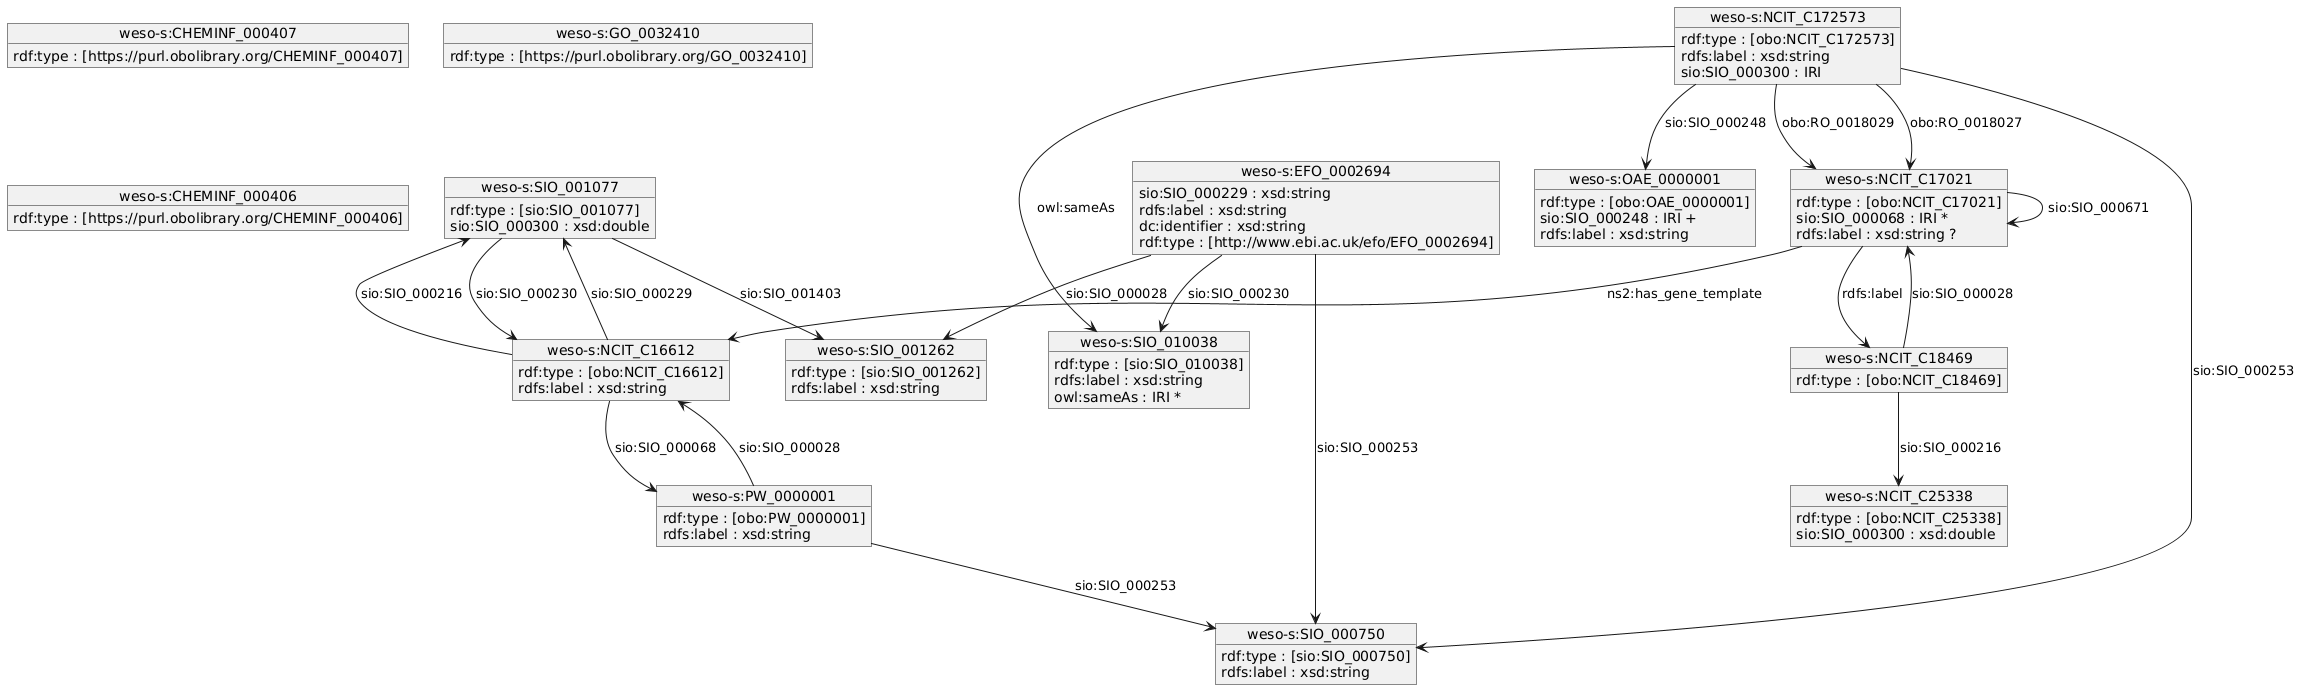

In [3]:
from shexer.shaper import Shaper
from shexer.consts import TURTLE
# Namespace-prefix pair to prettify the results
namespaces_dict = {
    "http://www.w3.org/1999/02/22-rdf-syntax-ns#": "rdf",
    "http://example.org/": "ex",
    "http://weso.es/shapes/": "",
    "http://www.w3.org/2001/XMLSchema#": "xsd",
    "http://www.w3.org/2002/07/owl#": "owl",
}
graph_path = os.path.join(os.getcwd(), "BDF_example_graph.ttl")

shaper = Shaper(
    all_classes_mode=True,
    graph_file_input=graph_path,
    input_format=TURTLE,
    namespaces_dict=namespaces_dict,
)  # Default rdf:type
rdf_png_path = os.path.join(os.getcwd(), "bdf_shexer.png")

result = shaper.shex_graph(string_output=True, acceptance_threshold=0.1, to_uml_path=rdf_png_path)
print(result)
from IPython.display import Image

Image(filename="bdf_shexer.png")